In [1]:
import re
from typing import NamedTuple, Dict, List, Tuple
from collections import defaultdict

import numpy as np
import networkx as nx
import igraph as ig

import leidenalg
import math

from sklearn.metrics import normalized_mutual_info_score
from tqdm.notebook import tqdm

from itertools import combinations
import community

import pandas as pd
import random

In [2]:
nets_count = 50
net_names = ['net_' + str(i) for i in range(nets_count)]

number_of_nodes = 500
average_degree = 7
maximal_degree = 21

mu = [i/nets_count for i in range(nets_count)] # mixing parameter
tau1 = 3 # degree powerlay
tau2 = 1.5

number_of_layers = 3
degree_change_chance = 0.3
membership_swap_chance = [0, 0.2]
layer_mixing = 1.5


In [3]:
df_info = pd.DataFrame({'net': net_names,
                        'mu': mu,
                        'tau1': tau1,
                        'tau2': tau2,})
df_info.head()

,net,mu,tau1,tau2
0,net_0,0.00,3,1.5
1,net_1,0.02,3,1.5
2,net_2,0.04,3,1.5
3,net_3,0.06,3,1.5
4,net_4,0.08,3,1.5


In [4]:
DATA_STORAGE = r'../LFR_nets/'

In [5]:
class Network(NamedTuple):
    
    network: List[nx.Graph]
    communities: Dict[int, int]

### Data reading and processing functions

In [6]:
def read_net_from_txt(path, net_name, layers_num = 3):
    
    def create_communities(communities):
        communities_dict = {}
        for pair in communities:
            try:
                u = int(pair[0])
                comm = int(pair[1])
                communities_dict[u] = comm
            except:
                pass
        return communities_dict
    
    
    communities_file_name = path + net_name + r'_Community.txt'
    try:
        with open(communities_file_name, 'r') as f:
            communities = f.read()
    except:
        communities_file_name = path + net_name + r'_Layer1_Community.txt'
        with open(communities_file_name, 'r') as f:
            communities = f.read()
    communities = [row.split(' ') for row in communities.split('\n')] 
    
    communities = create_communities(communities)
    nodes = list(communities.keys())
    
    layers_list = []
    for layer in range(1, layers_num+1):
        layer_file_name = path + net_name + r'_Layer' + str(layer) + r'_Network.txt'
        with open(layer_file_name, 'r') as f:
            layer_edges = f.read()
        layer_edges = [row.split(' ') for row in layer_edges.split('\n')] 
        layer_nx = nx.Graph()
        layer_nx.add_nodes_from(nodes)
        
        for edge in layer_edges:
            try:
                u, v = int(edge[0]), int(edge[1])
                if u < v:
                    layer_nx.add_edge(u, v, weight=1)
                elif u > v and not layer_nx.has_edge(v, u):
                    layer_nx.add_edge(v, u, weight=1)
            except:
                pass
        layers_list.append(layer_nx)
    
    net = Network(layers_list, communities)
    return net

In [7]:
def build_gt_graphs(labels, train_nodes):
    train_nodes = np.array(train_nodes)
    
    graph = nx.Graph()
    graph.add_nodes_from(train_nodes)
    for unq_label in labels.keys():
        edges = combinations(train_nodes[np.isin(train_nodes, labels[unq_label])], 2)
        graph.add_edges_from(edges)
        del(edges)
    return graph

In [8]:
def random_walk(
    multiplex_net: List[nx.Graph],
    walk_size: int,
    max_steps: int, 
    labels: Dict[int, int]
) -> Tuple[Network]:
    
    all_nodes = list(multiplex_net[0].nodes())
    assert walk_size < len(all_nodes)
    
    train_nodes = []
    test_nodes = []
    
    while len(train_nodes) < walk_size:
        train_nodes.append(random.choice(all_nodes))
        for step in range(max_steps):
            node = train_nodes[-1]
            possible_nodes = []
            for layer in multiplex_net:
                possible_nodes.extend(list(layer[node]))
            next_node = random.choice(possible_nodes)
            train_nodes.append(next_node)
        train_nodes = list(set(train_nodes))
    
    test_nodes = list(set(all_nodes).difference(set(train_nodes)))
    
    train_net = [layer.subgraph(train_nodes) for layer in multiplex_net]
    test_net = [layer.subgraph(test_nodes) for layer in multiplex_net]
    
    train_labels = dict(map(lambda x: [x, labels[x]], train_nodes))
    test_labels = dict(map(lambda x: [x, labels[x]], test_nodes))

    return Network(train_net, train_labels), Network(test_net, test_labels)

In [9]:
def add_noise(
    multiplex_net: Network,
    mu: float,
    std: float,
) -> Network:
    all_edges = None
    layers_list = []
    for monoplex_net in multiplex_net.network:
        new_monoplex_net = monoplex_net.copy()
        nodes_list = sorted(list(new_monoplex_net.nodes()))
        
        if not all_edges:
            all_edges = list(combinations(nodes_list, 2))
        
        add_values = np.random.normal(mu, std, len(all_edges))
        for idx, u_v in enumerate(all_edges):
            u, v = u_v
            value = add_values[idx]
            if new_monoplex_net.has_edge(u, v):
                weight = new_monoplex_net[u][v]['weight']
                new_monoplex_net[u][v]['weight'] = weight+value if weight+value > 0 else weight
            elif new_monoplex_net.has_edge(v, u):
                weight = new_monoplex_net[v][u]['weight']
                new_monoplex_net[v][u]['weight'] = weight+value if weight+value > 0 else weight
            else:
                if value > 0.001:
                    new_monoplex_net.add_edge(u, v, weight=value)
        layers_list.append(new_monoplex_net)
        
    net = Network(layers_list, multiplex_net.communities)
    return net

In [10]:
def train_model(
    multiplex_net: Network,
    net_name: str
) -> pd.DataFrame:
    
    
    labels = defaultdict(list)
    for node, comm in multiplex_net.communities.items():
        labels[comm].append(node)
        
    gt_graph = build_gt_graphs(labels, list(multiplex_net.communities.keys()))
    assert nx.number_connected_components(gt_graph) == len(labels)
    
    gt_partition = community.best_partition(gt_graph)
    gt_partition = list(dict(sorted(gt_partition.items())).values())
    
    train_data = []
    for graph in multiplex_net.network:
        train_data.append(nx.adjacency_matrix(graph, nodelist=list(multiplex_net.network[0].nodes)))
        
    step_size = 20
    alpha_values = []
    nmi_arr = []
    
    for a1 in tqdm(range(0, step_size, 1)):
        for a2 in range(0, step_size - a1, 1):
            a3 = step_size - a1 - a2

            a1 /= step_size
            a2 /= step_size
            a3 /= step_size
            alpha = [a1, a2, a3]

            alpha_values.append(alpha)
            g_fusion_adj = 0
            for idx, adj_matrix in enumerate(train_data):
                g_fusion_adj += alpha[idx]*adj_matrix
            g_fusion = nx.from_scipy_sparse_matrix(g_fusion_adj, parallel_edges=False, edge_attribute='weight')

            partition = community.best_partition(g_fusion)
            partition = list(dict(sorted(partition.items())).values())
            nmi = normalized_mutual_info_score(gt_partition, partition)
            nmi_arr.append(nmi)
    
    nmi_max = np.max(nmi_arr)
    nmi_avg = np.mean(nmi_arr)
    nmi_std = np.std(nmi_arr)
    alpha_max = alpha_values[np.nonzero(np.array(nmi_arr) == np.max(nmi_arr))[0][0]]
    
    result = {'net': net_name,'nmi_max': nmi_max,
              'nmi_avg': nmi_avg,'nmi_std': nmi_std, 
              'a1': alpha_max[0], 'a2': alpha_max[1], 'a3': alpha_max[2]}
    return result

In [11]:
def test_model(
    multiplex_net: Network,
    weight: List[float]
) -> pd.DataFrame:
    
    df_result = pd.DataFrame()
    
    gt_partition = multiplex_net.communities
    gt_partition = list(dict(sorted(gt_partition.items())).values()) 
    
    test_data = []
    for graph in multiplex_net.network:
        test_data.append(nx.adjacency_matrix(graph, nodelist=list(multiplex_net.network[0].nodes)))
        
    g_fusion_adj = 0
    for idx, adj_matrix in enumerate(test_data):
        g_fusion_adj += weight[idx]*adj_matrix
    g_fusion = nx.from_scipy_sparse_matrix(g_fusion_adj, parallel_edges=False, edge_attribute='weight')
    
    partition = community.best_partition(g_fusion)
    partition = list(dict(sorted(partition.items())).values())
    
    nmi = normalized_mutual_info_score(gt_partition, partition)
    return nmi

In [12]:
def run_experiment(
    path : str,
    net_names : List[str],
    mean : float, 
    std : float
) -> pd.DataFrame:
    
    df_result = pd.DataFrame()
    for net_name in tqdm(net_names):
        network = read_net_from_txt(path, net_name)
        train_net, test_net = network, add_noise(network, mean, std)
        result = train_model(train_net, net_name)
        nmi_test = test_model(test_net, [result['a1'], result['a2'], result['a3']])
        df_result = df_result.append(pd.Series({'net': result['net'], 
                                  'nmi_max': result['nmi_max'], 
                                  'nmi_avg': result['nmi_avg'],
                                  'nmi_std': result['nmi_std'],
                                  'a1': result['a1'],
                                  'a2': result['a2'],
                                  'a3': result['a3'],
                                  'nmi_test': nmi_test}), ignore_index=True)
    return df_result

## 1. STD = 0.1, MEAN = 0

### 1. 1. membership_swap_chance = 0

In [29]:
res_1_1 = run_experiment(
                path=DATA_STORAGE + r'/mlp0/',
                net_names=net_names,
                mean=0,
                std=0.1 
                )

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

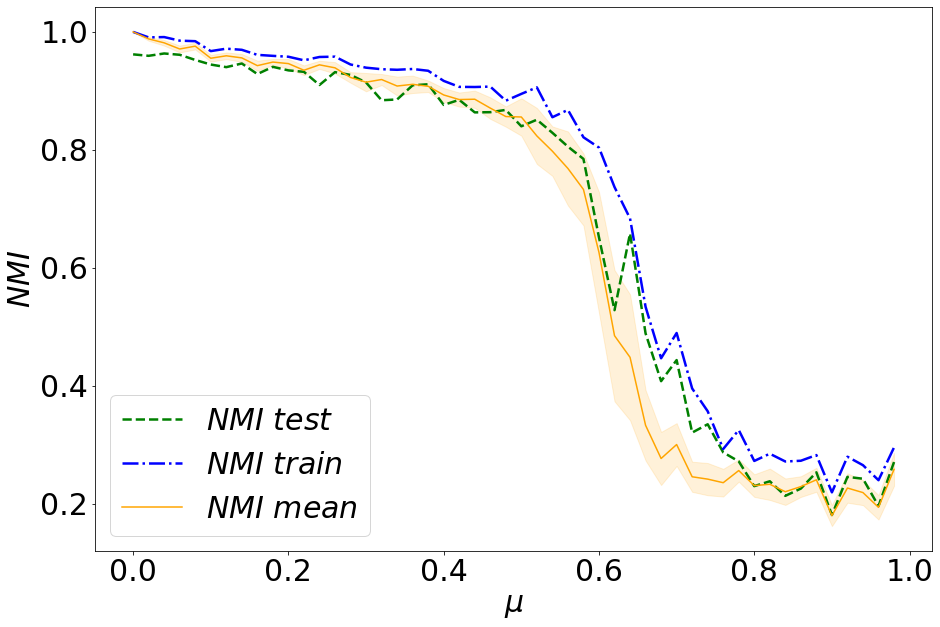

In [33]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

df_result = res_1_1
result = pd.concat((df_result, df_info.mu), axis=1)
alphas_result = pd.DataFrame({'alpha': result[['a1', 'a2', 'a3']].idxmax(axis=1),
                              'value': result[['a1', 'a2', 'a3']].max(axis=1),
                              'mu': result.mu,
                              'nmi_max': result.nmi_max})
plt.rcParams['figure.figsize'] = (15, 10)

ax1 = plt.subplot()

ax1.plot(result.mu, result.nmi_test, color='green', linestyle='dashed', linewidth= 2.5, label=r"${NMI~test}$")
ax1.plot(result.mu, result.nmi_max, color='blue', linestyle='dashdot', linewidth= 2.5, label=r"${NMI~train}$")
ax1.plot(result.mu, result.nmi_avg, color='orange', label='${NMI~mean}$')
ax1.fill_between(result.mu, [el1-el2 for (el1, el2) in zip(list(result.nmi_avg),list(result.nmi_std))], 
                [el1+el2 for (el1, el2) in zip(list(result.nmi_avg),list(result.nmi_std))], color='orange', alpha=.15)

ax1.legend(loc='lower left', prop={'size': 30})
ax1.set_xlabel(r'$\mu$', fontsize=30)
ax1.set_ylabel(r'$NMI$', fontsize=30)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)
plt.savefig('../Results/NMI_0_0_01.png', dpi=300)

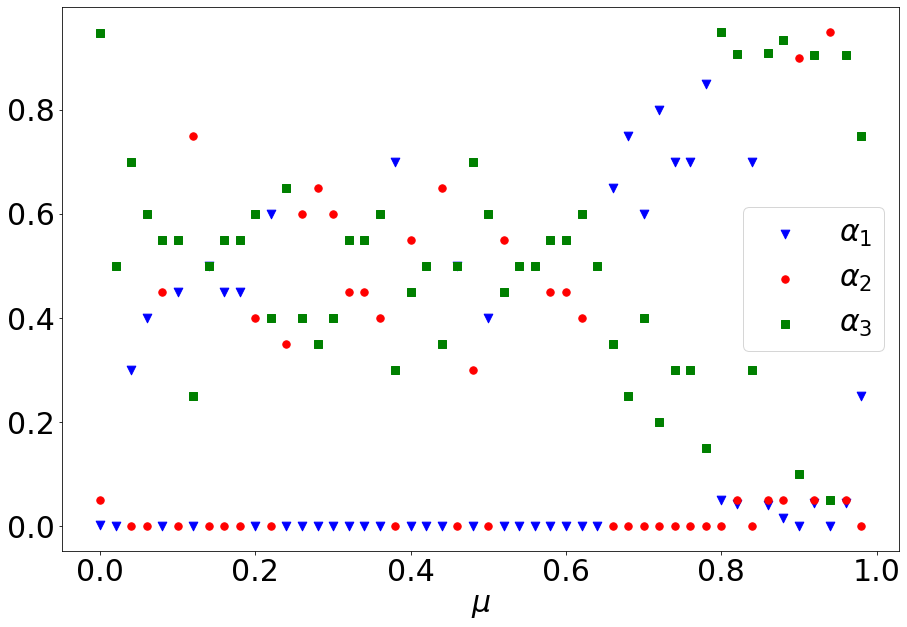

In [34]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

df_result = res_1_1
result = pd.concat((df_result, df_info.mu), axis=1)
alphas_result = pd.DataFrame({'alpha': result[['a1', 'a2', 'a3']].idxmax(axis=1),
                              'value': result[['a1', 'a2', 'a3']].max(axis=1),
                              'mu': result.mu,
                              'nmi_max': result.nmi_max})
plt.rcParams['figure.figsize'] = (15, 10)

ax1 = plt.subplot()
ax1.scatter(alphas_result.mu, 
            df_result.a1, marker = 'v', s = 75,
            color='blue', label=r"${\alpha}_1}$")
ax1.scatter(alphas_result.mu, 
            df_result.a2, marker = 'o', s = 55,
            color='red', label=r"${\alpha}_2}$")

ax1.scatter(alphas_result.mu, 
            df_result.a3, marker = 's', s = 65,
            color='green', label=r"${{\alpha}_3}$")

ax1.legend(loc='best', prop={'size': 30})
ax1.set_xlabel(r'$\mu$', fontsize=30)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)
plt.savefig('../Results/alpha_0_0_01.png', dpi=300)

In [43]:
res_1_1.to_csv(r"../Results/data_0_0_01/result.csv", index=False)

### 1. 2. membership_swap_chance = 0.2

In [35]:
res_1_2 = run_experiment(
                path=DATA_STORAGE + r'/mlp2/',
                net_names=net_names,
                mean=0,
                std=0.1 
                )

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

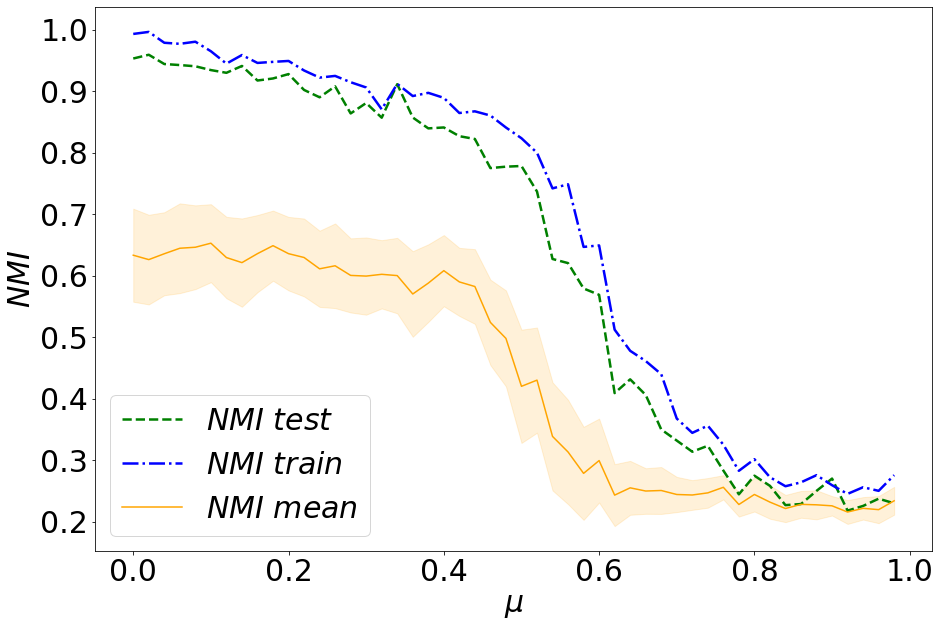

In [39]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

df_result = res_1_2
result = pd.concat((df_result, df_info.mu), axis=1)
alphas_result = pd.DataFrame({'alpha': result[['a1', 'a2', 'a3']].idxmax(axis=1),
                              'value': result[['a1', 'a2', 'a3']].max(axis=1),
                              'mu': result.mu,
                              'nmi_max': result.nmi_max})
plt.rcParams['figure.figsize'] = (15, 10)

ax1 = plt.subplot()

ax1.plot(result.mu, result.nmi_test, color='green', linestyle='dashed', linewidth= 2.5, label=r"${NMI~test}$")
ax1.plot(result.mu, result.nmi_max, color='blue', linestyle='dashdot', linewidth= 2.5, label=r"${NMI~train}$")
ax1.plot(result.mu, result.nmi_avg, color='orange', label='${NMI~mean}$')
ax1.fill_between(result.mu, [el1-el2 for (el1, el2) in zip(list(result.nmi_avg),list(result.nmi_std))], 
                [el1+el2 for (el1, el2) in zip(list(result.nmi_avg),list(result.nmi_std))], color='orange', alpha=.15)

ax1.legend(loc='lower left', prop={'size': 30})
ax1.set_xlabel(r'$\mu$', fontsize=30)
ax1.set_ylabel(r'$NMI$', fontsize=30)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)
plt.savefig('../Results/NMI_02_0_01.png', dpi=300)

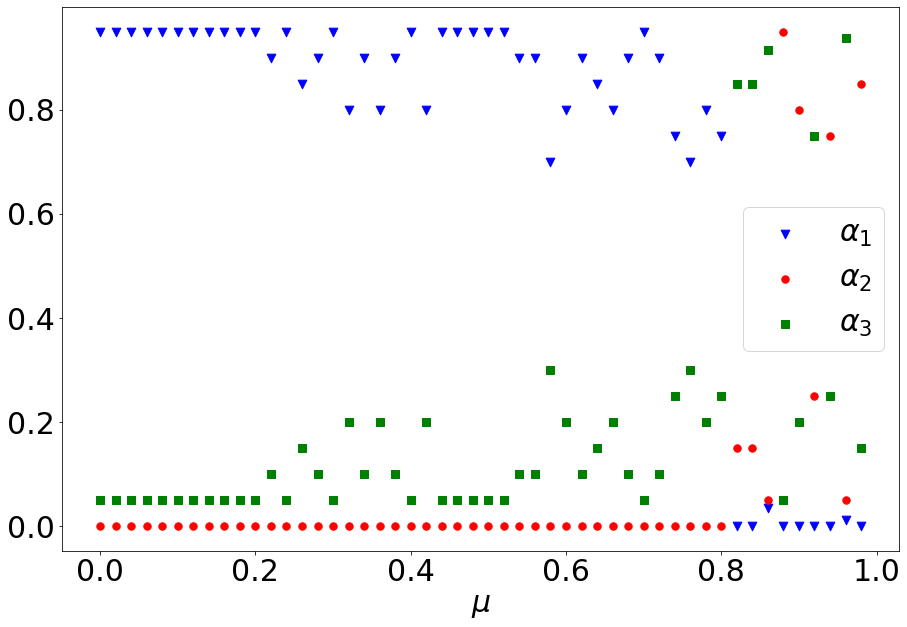

In [40]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

df_result = res_1_2
result = pd.concat((df_result, df_info.mu), axis=1)
alphas_result = pd.DataFrame({'alpha': result[['a1', 'a2', 'a3']].idxmax(axis=1),
                              'value': result[['a1', 'a2', 'a3']].max(axis=1),
                              'mu': result.mu,
                              'nmi_max': result.nmi_max})
plt.rcParams['figure.figsize'] = (15, 10)

ax1 = plt.subplot()
ax1.scatter(alphas_result.mu, 
            df_result.a1, marker = 'v', s = 75,
            color='blue', label=r"${\alpha}_1}$")
ax1.scatter(alphas_result.mu, 
            df_result.a2, marker = 'o', s = 55,
            color='red', label=r"${\alpha}_2}$")

ax1.scatter(alphas_result.mu, 
            df_result.a3, marker = 's', s = 65,
            color='green', label=r"${{\alpha}_3}$")

ax1.legend(loc='best', prop={'size': 30})
ax1.set_xlabel(r'$\mu$', fontsize=30)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)
plt.savefig('../Results/alpha_02_0_01.png', dpi=300)

In [42]:
res_1_2.to_csv(r"../Results/data_02_0_01/result.csv", index=False)

## 2. STD = 0.3, MEAN = 0

### 2. 1. membership_swap_chance = 0

In [44]:
res_2_1 = run_experiment(
                path=DATA_STORAGE + r'/mlp0/',
                net_names=net_names,
                mean=0,
                std=0.3 
                )

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

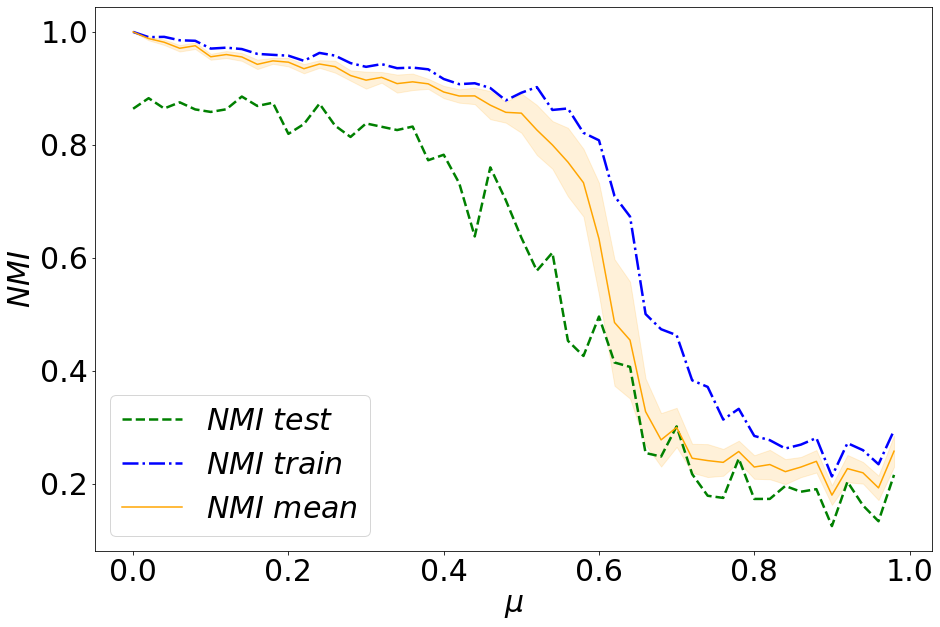

In [50]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

df_result = res_2_1
result = pd.concat((df_result, df_info.mu), axis=1)
alphas_result = pd.DataFrame({'alpha': result[['a1', 'a2', 'a3']].idxmax(axis=1),
                              'value': result[['a1', 'a2', 'a3']].max(axis=1),
                              'mu': result.mu,
                              'nmi_max': result.nmi_max})
plt.rcParams['figure.figsize'] = (15, 10)

ax1 = plt.subplot()

ax1.plot(result.mu, result.nmi_test, color='green', linestyle='dashed', linewidth= 2.5, label=r"${NMI~test}$")
ax1.plot(result.mu, result.nmi_max, color='blue', linestyle='dashdot', linewidth= 2.5, label=r"${NMI~train}$")
ax1.plot(result.mu, result.nmi_avg, color='orange', label='${NMI~mean}$')
ax1.fill_between(result.mu, [el1-el2 for (el1, el2) in zip(list(result.nmi_avg),list(result.nmi_std))], 
                [el1+el2 for (el1, el2) in zip(list(result.nmi_avg),list(result.nmi_std))], color='orange', alpha=.15)

ax1.legend(loc='lower left', prop={'size': 30})
ax1.set_xlabel(r'$\mu$', fontsize=30)
ax1.set_ylabel(r'$NMI$', fontsize=30)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)
plt.savefig('../Results/NMI_0_0_03.png', dpi=300)

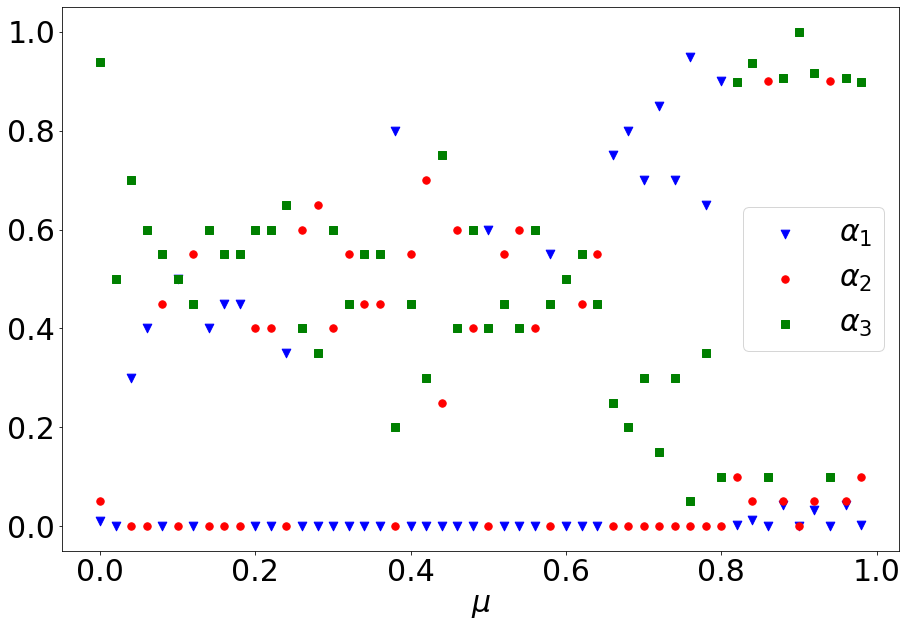

In [51]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

df_result = res_2_1
result = pd.concat((df_result, df_info.mu), axis=1)
alphas_result = pd.DataFrame({'alpha': result[['a1', 'a2', 'a3']].idxmax(axis=1),
                              'value': result[['a1', 'a2', 'a3']].max(axis=1),
                              'mu': result.mu,
                              'nmi_max': result.nmi_max})
plt.rcParams['figure.figsize'] = (15, 10)

ax1 = plt.subplot()
ax1.scatter(alphas_result.mu, 
            df_result.a1, marker = 'v', s = 75,
            color='blue', label=r"${\alpha}_1}$")
ax1.scatter(alphas_result.mu, 
            df_result.a2, marker = 'o', s = 55,
            color='red', label=r"${\alpha}_2}$")

ax1.scatter(alphas_result.mu, 
            df_result.a3, marker = 's', s = 65,
            color='green', label=r"${{\alpha}_3}$")

ax1.legend(loc='best', prop={'size': 30})
ax1.set_xlabel(r'$\mu$', fontsize=30)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)
plt.savefig('../Results/alpha_0_0_03.png', dpi=300)

In [52]:
res_2_1.to_csv(r"../Results/data_0_0_03/result.csv", index=False)

### 2. 2. membership_swap_chance = 0.2

In [45]:
res_2_2 = run_experiment(
                path=DATA_STORAGE + r'/mlp2/',
                net_names=net_names,
                mean=0,
                std=0.3
                )

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

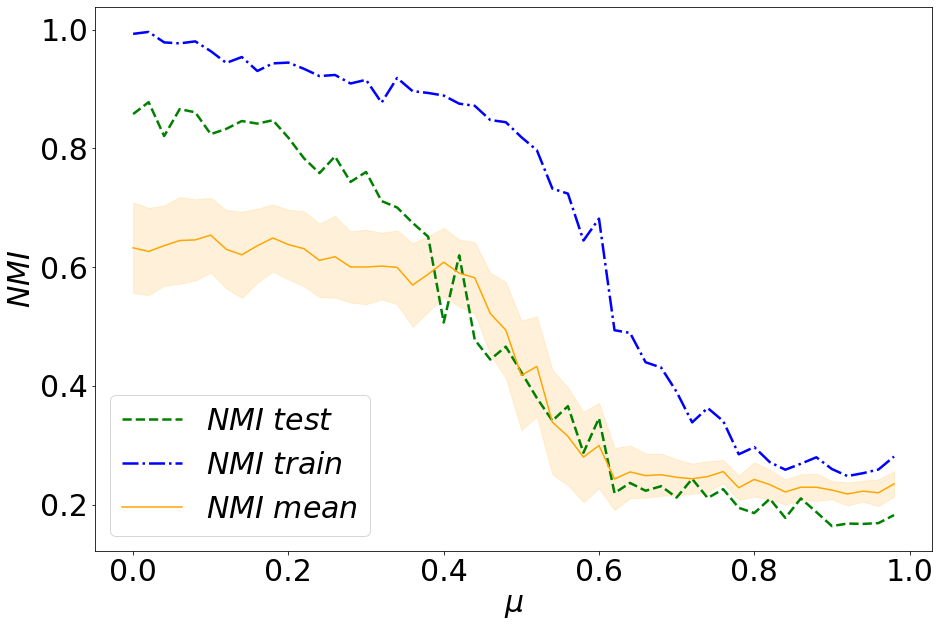

In [54]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

df_result = res_2_2
result = pd.concat((df_result, df_info.mu), axis=1)
alphas_result = pd.DataFrame({'alpha': result[['a1', 'a2', 'a3']].idxmax(axis=1),
                              'value': result[['a1', 'a2', 'a3']].max(axis=1),
                              'mu': result.mu,
                              'nmi_max': result.nmi_max})
plt.rcParams['figure.figsize'] = (15, 10)

ax1 = plt.subplot()

ax1.plot(result.mu, result.nmi_test, color='green', linestyle='dashed', linewidth= 2.5, label=r"${NMI~test}$")
ax1.plot(result.mu, result.nmi_max, color='blue', linestyle='dashdot', linewidth= 2.5, label=r"${NMI~train}$")
ax1.plot(result.mu, result.nmi_avg, color='orange', label='${NMI~mean}$')
ax1.fill_between(result.mu, [el1-el2 for (el1, el2) in zip(list(result.nmi_avg),list(result.nmi_std))], 
                [el1+el2 for (el1, el2) in zip(list(result.nmi_avg),list(result.nmi_std))], color='orange', alpha=.15)

ax1.legend(loc='lower left', prop={'size': 30})
ax1.set_xlabel(r'$\mu$', fontsize=30)
ax1.set_ylabel(r'$NMI$', fontsize=30)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)
plt.savefig('../Results/NMI_02_0_03.png', dpi=300)

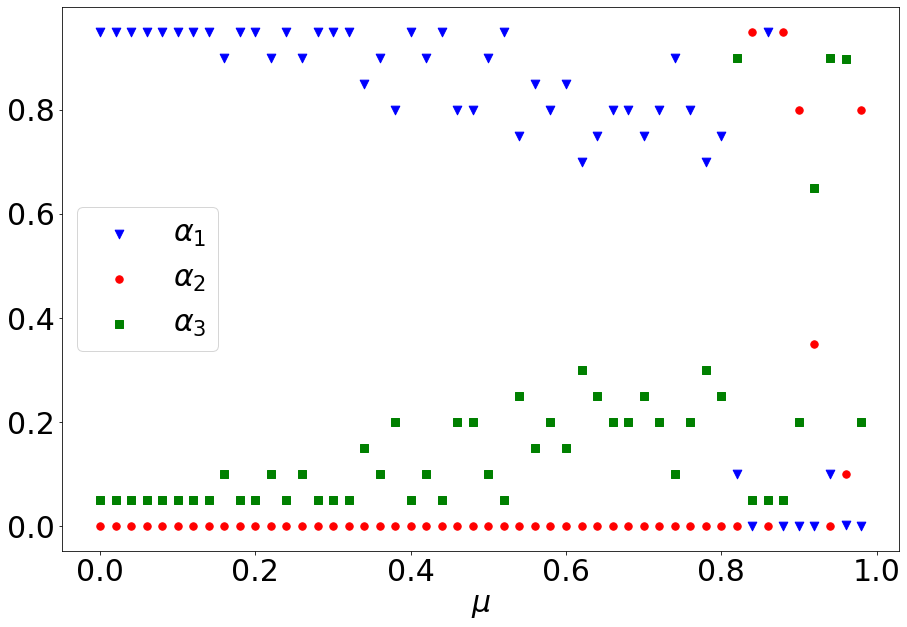

In [55]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

df_result = res_2_2
result = pd.concat((df_result, df_info.mu), axis=1)
alphas_result = pd.DataFrame({'alpha': result[['a1', 'a2', 'a3']].idxmax(axis=1),
                              'value': result[['a1', 'a2', 'a3']].max(axis=1),
                              'mu': result.mu,
                              'nmi_max': result.nmi_max})
plt.rcParams['figure.figsize'] = (15, 10)

ax1 = plt.subplot()
ax1.scatter(alphas_result.mu, 
            df_result.a1, marker = 'v', s = 75,
            color='blue', label=r"${\alpha}_1}$")
ax1.scatter(alphas_result.mu, 
            df_result.a2, marker = 'o', s = 55,
            color='red', label=r"${\alpha}_2}$")

ax1.scatter(alphas_result.mu, 
            df_result.a3, marker = 's', s = 65,
            color='green', label=r"${{\alpha}_3}$")

ax1.legend(loc='best', prop={'size': 30})
ax1.set_xlabel(r'$\mu$', fontsize=30)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)
plt.savefig('../Results/alpha_02_0_03.png', dpi=300)

In [56]:
res_2_2.to_csv(r"../Results/data_02_0_03/result.csv", index=False)

## 3. STD = 0.5, MEAN = 0

### 3. 1. membership_swap_chance = 0

In [13]:
res_3_1 = run_experiment(
                path=DATA_STORAGE + r'/mlp0/',
                net_names=net_names,
                mean=0,
                std=0.5
                )

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

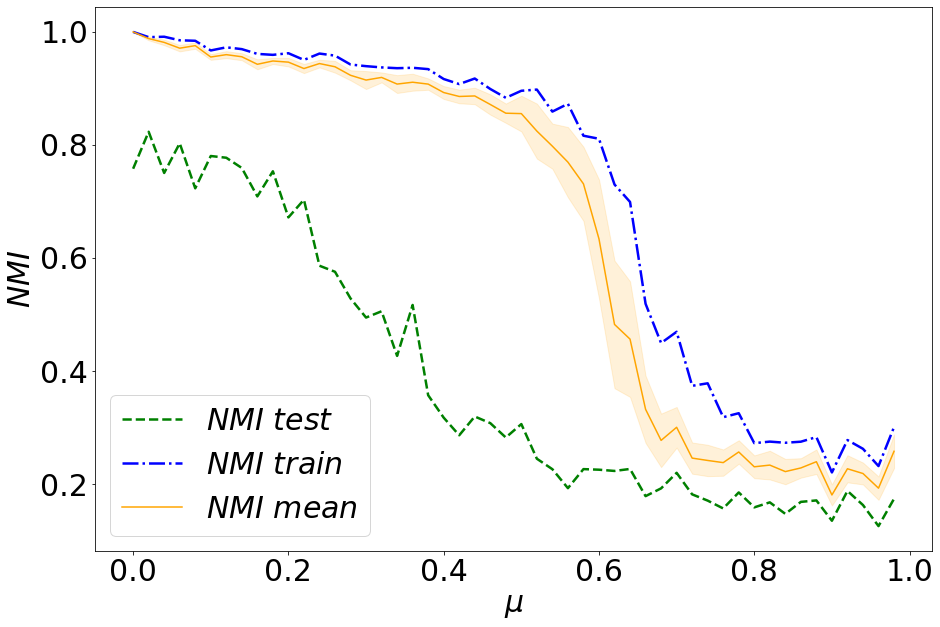

In [21]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

df_result = res_3_1
result = pd.concat((df_result, df_info.mu), axis=1)
alphas_result = pd.DataFrame({'alpha': result[['a1', 'a2', 'a3']].idxmax(axis=1),
                              'value': result[['a1', 'a2', 'a3']].max(axis=1),
                              'mu': result.mu,
                              'nmi_max': result.nmi_max})
plt.rcParams['figure.figsize'] = (15, 10)

ax1 = plt.subplot()

ax1.plot(result.mu, result.nmi_test, color='green', linestyle='dashed', linewidth= 2.5, label=r"${NMI~test}$")
ax1.plot(result.mu, result.nmi_max, color='blue', linestyle='dashdot', linewidth= 2.5, label=r"${NMI~train}$")
ax1.plot(result.mu, result.nmi_avg, color='orange', label='${NMI~mean}$')
ax1.fill_between(result.mu, [el1-el2 for (el1, el2) in zip(list(result.nmi_avg),list(result.nmi_std))], 
                [el1+el2 for (el1, el2) in zip(list(result.nmi_avg),list(result.nmi_std))], color='orange', alpha=.15)

ax1.legend(loc='lower left', prop={'size': 30})
ax1.set_xlabel(r'$\mu$', fontsize=30)
ax1.set_ylabel(r'$NMI$', fontsize=30)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)
plt.savefig('../Results/NMI_0_0_05.png', dpi=300)

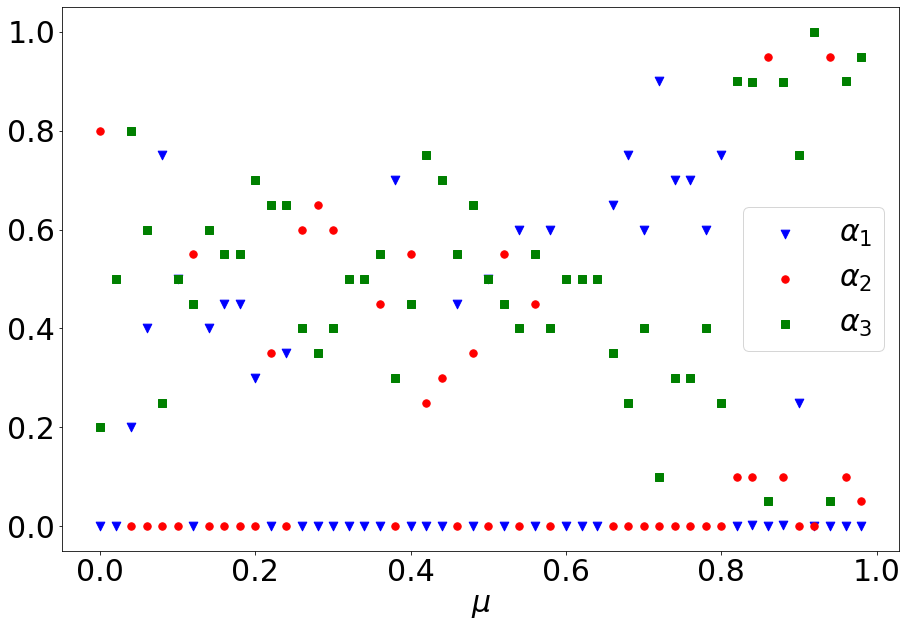

In [22]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

df_result = res_3_1
result = pd.concat((df_result, df_info.mu), axis=1)
alphas_result = pd.DataFrame({'alpha': result[['a1', 'a2', 'a3']].idxmax(axis=1),
                              'value': result[['a1', 'a2', 'a3']].max(axis=1),
                              'mu': result.mu,
                              'nmi_max': result.nmi_max})
plt.rcParams['figure.figsize'] = (15, 10)

ax1 = plt.subplot()
ax1.scatter(alphas_result.mu, 
            df_result.a1, marker = 'v', s = 75,
            color='blue', label=r"${\alpha}_1}$")
ax1.scatter(alphas_result.mu, 
            df_result.a2, marker = 'o', s = 55,
            color='red', label=r"${\alpha}_2}$")

ax1.scatter(alphas_result.mu, 
            df_result.a3, marker = 's', s = 65,
            color='green', label=r"${{\alpha}_3}$")

ax1.legend(loc='best', prop={'size': 30})
ax1.set_xlabel(r'$\mu$', fontsize=30)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)
plt.savefig('../Results/alpha_0_0_05.png', dpi=300)

In [25]:
res_3_1.to_csv(r"../Results/data_0_05/result.csv", index=False)

### 3. 2. membership_swap_chance = 0.2

In [14]:
res_3_2 = run_experiment(
                path=DATA_STORAGE + r'/mlp2/',
                net_names=net_names,
                mean=0,
                std=0.5
                )

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

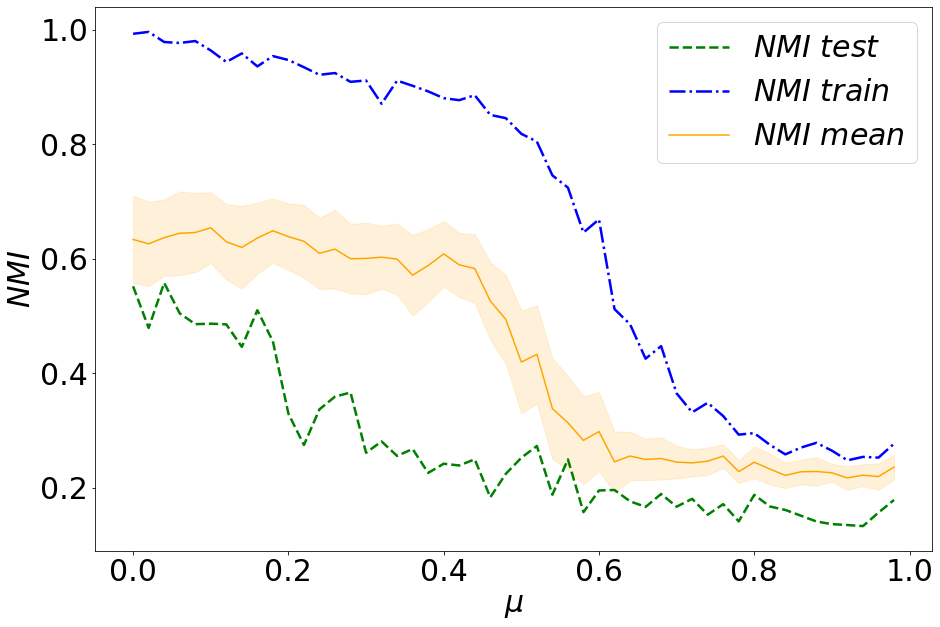

In [23]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

df_result = res_3_2
result = pd.concat((df_result, df_info.mu), axis=1)
alphas_result = pd.DataFrame({'alpha': result[['a1', 'a2', 'a3']].idxmax(axis=1),
                              'value': result[['a1', 'a2', 'a3']].max(axis=1),
                              'mu': result.mu,
                              'nmi_max': result.nmi_max})
plt.rcParams['figure.figsize'] = (15, 10)

ax1 = plt.subplot()

ax1.plot(result.mu, result.nmi_test, color='green', linestyle='dashed', linewidth= 2.5, label=r"${NMI~test}$")
ax1.plot(result.mu, result.nmi_max, color='blue', linestyle='dashdot', linewidth= 2.5, label=r"${NMI~train}$")
ax1.plot(result.mu, result.nmi_avg, color='orange', label='${NMI~mean}$')
ax1.fill_between(result.mu, [el1-el2 for (el1, el2) in zip(list(result.nmi_avg),list(result.nmi_std))], 
                [el1+el2 for (el1, el2) in zip(list(result.nmi_avg),list(result.nmi_std))], color='orange', alpha=.15)

ax1.legend(loc='upper right', prop={'size': 30})
ax1.set_xlabel(r'$\mu$', fontsize=30)
ax1.set_ylabel(r'$NMI$', fontsize=30)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)
plt.savefig('../Results/NMI_02_0_05.png', dpi=300)

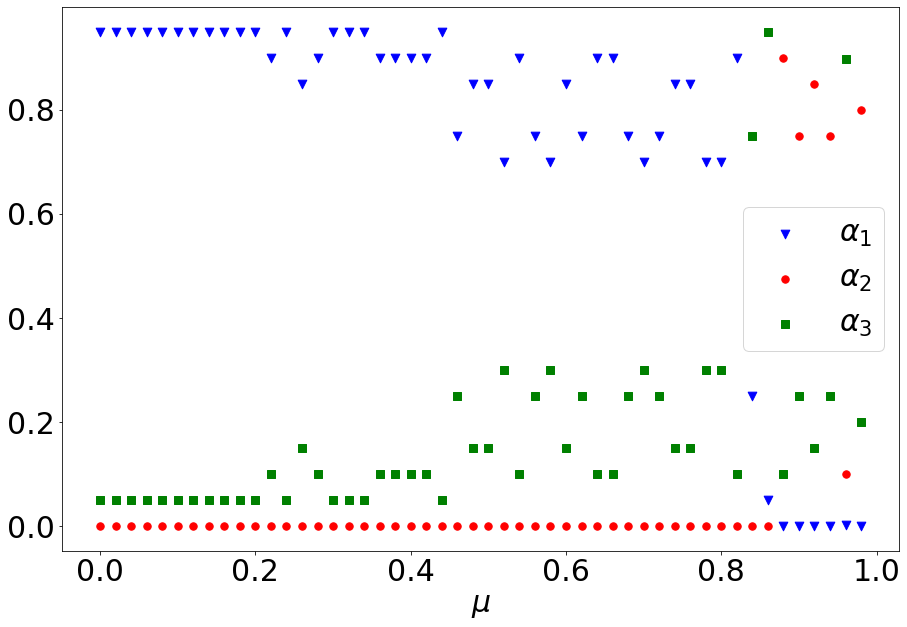

In [24]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

df_result = res_3_2
result = pd.concat((df_result, df_info.mu), axis=1)
alphas_result = pd.DataFrame({'alpha': result[['a1', 'a2', 'a3']].idxmax(axis=1),
                              'value': result[['a1', 'a2', 'a3']].max(axis=1),
                              'mu': result.mu,
                              'nmi_max': result.nmi_max})
plt.rcParams['figure.figsize'] = (15, 10)

ax1 = plt.subplot()
ax1.scatter(alphas_result.mu, 
            df_result.a1, marker = 'v', s = 75,
            color='blue', label=r"${\alpha}_1}$")
ax1.scatter(alphas_result.mu, 
            df_result.a2, marker = 'o', s = 55,
            color='red', label=r"${\alpha}_2}$")

ax1.scatter(alphas_result.mu, 
            df_result.a3, marker = 's', s = 65,
            color='green', label=r"${{\alpha}_3}$")

ax1.legend(loc='best', prop={'size': 30})
ax1.set_xlabel(r'$\mu$', fontsize=30)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)
plt.savefig('../Results/alpha_02_0_05.png', dpi=300)

In [26]:
res_3_2.to_csv(r"../Results/data_02_05/result.csv", index=False)

## Comparison figure

In [32]:
columns = ['nmi_avg', 'nmi_max', 'nmi_std', 'nmi_test']
res_3_2 = pd.read_csv(r"../Results/data_02_05/result.csv")[columns]
res_3_1 = pd.read_csv(r"../Results/data_0_05/result.csv")[columns]
res_2_2 = pd.read_csv(r"../Results/data_02_03/result.csv")[columns]
res_2_1 = pd.read_csv(r"../Results/data_0_03/result.csv")[columns]
res_1_2 = pd.read_csv(r"../Results/data_02_01/result.csv")[columns]
res_1_1 = pd.read_csv(r"../Results/data_0_01/result.csv")[columns]

swap_arr = [res_1_2, res_2_2, res_3_2]
no_swap_arr = [res_1_1, res_2_1, res_3_1]

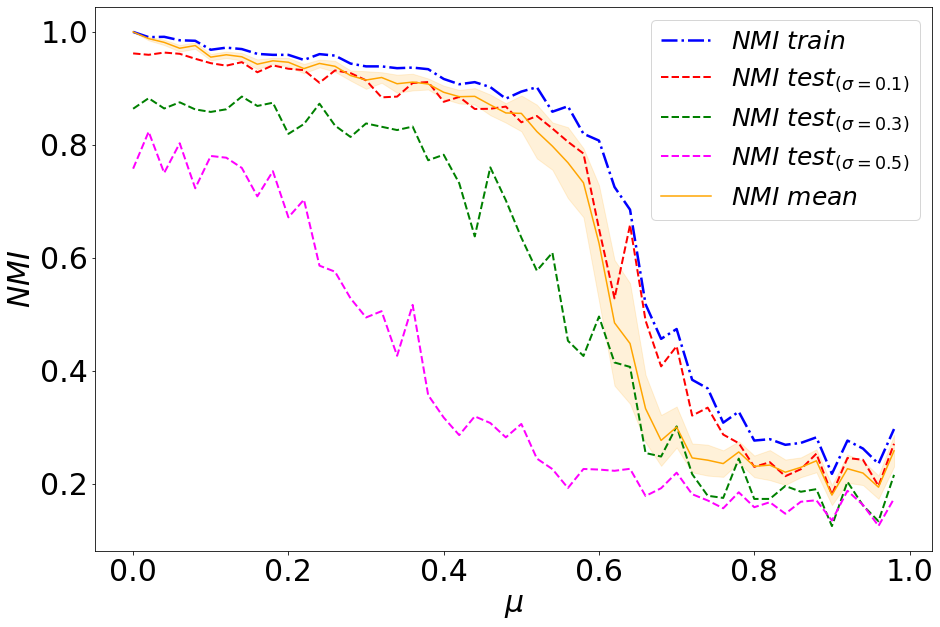

In [96]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

df_result = res_3_2
plt.rcParams['figure.figsize'] = (15, 10)

ax1 = plt.subplot()
ax1.plot(df_info.mu, (no_swap_arr[0].nmi_max + no_swap_arr[1].nmi_max + no_swap_arr[2].nmi_max)/3, color='blue', linestyle='dashdot', linewidth= 2.5, label=r"${NMI~train}$")

ax1.plot(df_info.mu, no_swap_arr[0].nmi_test, color='red', linestyle='dashed', linewidth= 2, label=r"${NMI~test_{(\sigma=0.1)}}$")
ax1.plot(df_info.mu, no_swap_arr[1].nmi_test, color='green', linestyle='dashed', linewidth= 2, label=r"${NMI~test_{(\sigma=0.3)}}$")
ax1.plot(df_info.mu, no_swap_arr[2].nmi_test, color='magenta', linestyle='dashed', linewidth= 2, label=r"${NMI~test_{(\sigma=0.5)}}$")

ax1.plot(df_info.mu, no_swap_arr[0].nmi_avg, color='orange', label='${NMI~mean}$')
ax1.fill_between(df_info.mu, [el1-el2 for (el1, el2) in zip(list(no_swap_arr[0].nmi_avg),list(no_swap_arr[0].nmi_std))], 
                [el1+el2 for (el1, el2) in zip(list(no_swap_arr[0].nmi_avg),list(no_swap_arr[0].nmi_std))], color='orange', alpha=.15)


ax1.legend(loc='best', prop={'size': 25})
ax1.set_xlabel(r'$\mu$', fontsize=30)
ax1.set_ylabel(r'$NMI$', fontsize=30)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)

plt.savefig('../Results/NMI_0_all.png', dpi=300)

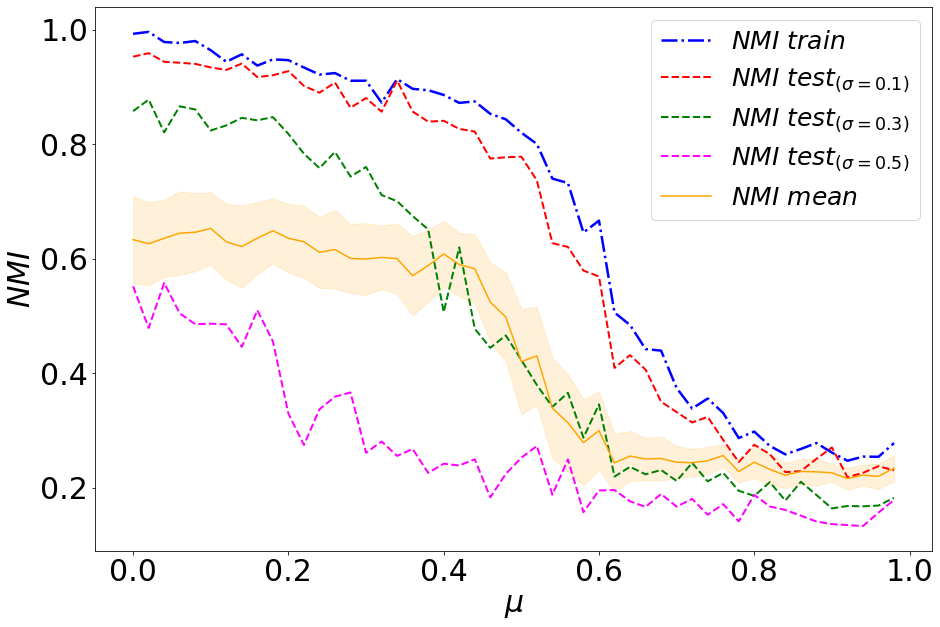

In [97]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

df_result = res_3_2
plt.rcParams['figure.figsize'] = (15, 10)

ax1 = plt.subplot()
ax1.plot(df_info.mu, (swap_arr[0].nmi_max + swap_arr[1].nmi_max + swap_arr[2].nmi_max)/3, color='blue', linestyle='dashdot', linewidth= 2.5, label=r"${NMI~train}$")

ax1.plot(df_info.mu, swap_arr[0].nmi_test, color='red', linestyle='dashed', linewidth= 2, label=r"${NMI~test_{(\sigma=0.1)}}$")
ax1.plot(df_info.mu, swap_arr[1].nmi_test, color='green', linestyle='dashed', linewidth= 2, label=r"${NMI~test_{(\sigma=0.3)}}$")
ax1.plot(df_info.mu, swap_arr[2].nmi_test, color='magenta', linestyle='dashed', linewidth= 2, label=r"${NMI~test_{(\sigma=0.5)}}$")

ax1.plot(df_info.mu, swap_arr[0].nmi_avg, color='orange', label='${NMI~mean}$')
ax1.fill_between(df_info.mu, [el1-el2 for (el1, el2) in zip(list(swap_arr[0].nmi_avg),list(swap_arr[0].nmi_std))], 
                [el1+el2 for (el1, el2) in zip(list(swap_arr[0].nmi_avg),list(swap_arr[0].nmi_std))], color='orange', alpha=.15)


ax1.legend(loc='best', prop={'size': 25})
ax1.set_xlabel(r'$\mu$', fontsize=30)
ax1.set_ylabel(r'$NMI$', fontsize=30)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)

plt.savefig('../Results/NMI_02_all.png', dpi=300)